In [1]:
import pandas as pd

In [2]:
from sklearn.preprocessing import normalize, minmax_scale
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, Birch
from sklearn.manifold import TSNE

In [3]:
from tslearn.clustering import TimeSeriesKMeans
import plotly.graph_objects as go
import seaborn as sns

In [4]:
%matplotlib inline

In [5]:
updated_df = updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [6]:
US_input_df = updated_df.copy()
US_input_df = US_input_df[US_input_df["location_name"] == "US"]
US_input_df = US_input_df[["date", "value"]]
US_input_df["date"] = pd.to_datetime(US_input_df["date"])
US_input_df.set_index("date", inplace = True)
US_input_df.sort_values(by = "date", inplace = True)
US_input_df["ds"] = US_input_df.index
US_input_df["unique_id"] = "series_1"
US_input_df.rename(columns = {"value": "y"}, inplace=True)

US_true_df = US_input_df.copy()

US_input_df = US_input_df.loc[:"12-15-2024"]

In [7]:
all_input_df = updated_df.copy()
all_input_df = all_input_df[["date", "value", "location_name"]]
all_input_df["date"] = pd.to_datetime(all_input_df["date"])
all_input_df.sort_values(by = ["location_name", "date"], inplace = True)
all_input_df.rename(columns = {"date": "ds", "value": "y", "location_name": "unique_id"}, inplace = True)

all_input_df = all_input_df[all_input_df["ds"] <= "12-15-2024"]

all_input_df['y'] = (
    all_input_df
      .groupby('unique_id', group_keys=False)['y']
      .apply(lambda s: s.interpolate(
          method='linear',
          limit_direction='both'
      ))
)

In [8]:
def create_windowed_df(df, input_size, stride=1):
    windows = []
    for original_id, group in df.groupby("unique_id", sort=False):
        for i in range(0, len(group) - input_size + 1, stride):
            window = group.iloc[i : i + input_size].copy()
            window["unique_id"] = (
                window["unique_id"].astype(str)
                + "_"
                + f"window_{i:03d}"
            )
            windows.append(window)
    return pd.concat(windows, ignore_index=True)

In [9]:
window_size = 12
windowed_all_df = create_windowed_df(all_input_df, input_size = window_size)

In [10]:
windowed_all_df

,ds,y,unique_id
0,2022-02-05,5.0,Alabama_window_000
1,2022-02-12,9.0,Alabama_window_000
2,2022-02-19,21.0,Alabama_window_000
3,2022-02-26,10.0,Alabama_window_000
4,2022-03-05,26.0,Alabama_window_000
...,...,...,...
88399,2024-11-16,4.0,Wyoming_window_138
88400,2024-11-23,8.0,Wyoming_window_138
88401,2024-11-30,7.0,Wyoming_window_138
88402,2024-12-07,5.0,Wyoming_window_138


In [11]:
windowed_all_df["mod"] = windowed_all_df.index % window_size

In [12]:
#Reshape and Normalize
df = windowed_all_df.pivot(index = "unique_id", columns = "mod", values="y")
aux = df.copy()
scaled_matrix = minmax_scale(df.values.T).T
df = pd.DataFrame(scaled_matrix)
df.index = aux.index
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
unique_id,,,,,,,,,,,,
Alabama_window_000,0.000000,0.133333,0.533333,0.166667,0.700000,1.000000,0.600000,0.400000,0.666667,0.600000,0.200000,0.666667
Alabama_window_001,0.000000,0.461538,0.038462,0.653846,1.000000,0.538462,0.307692,0.615385,0.538462,0.076923,0.615385,0.000000
Alabama_window_002,0.461538,0.038462,0.653846,1.000000,0.538462,0.307692,0.615385,0.538462,0.076923,0.615385,0.000000,0.384615
Alabama_window_003,0.038462,0.653846,1.000000,0.538462,0.307692,0.615385,0.538462,0.076923,0.615385,0.000000,0.384615,0.115385
Alabama_window_004,0.653846,1.000000,0.538462,0.307692,0.615385,0.538462,0.076923,0.615385,0.000000,0.384615,0.115385,0.230769


In [13]:
"""
X = df.values
dist = euclidean_distances(X, X)
dist = pd.DataFrame(dist)
dist.index = df.index
dist.columns = dist.index
dist
"""

'\nX = df.values\ndist = euclidean_distances(X, X)\ndist = pd.DataFrame(dist)\ndist.index = df.index\ndist.columns = dist.index\ndist\n'

In [14]:
#sns.heatmap(dist)

In [15]:
def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(100, 100), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)
    plt.savefig(file_name,bbox_inches="tight")
    del fig

In [16]:
"""
states = []
graphs = []

for index, row in dist.iterrows():
    states.append(index)
    for idx, value in row.sort_values(ascending=True)[1:3].items():
        graphs.append([index, idx, value])
        
graph = pd.DataFrame(graphs)
graph.columns = ["source", "destination", "weight"]
display(graph.head())

G = nx.from_pandas_edgelist(graph, source='source', target='destination',
                            edge_attr='weight')

save_graph(G,"my_graph.jpg")
"""

'\nstates = []\ngraphs = []\n\nfor index, row in dist.iterrows():\n    states.append(index)\n    for idx, value in row.sort_values(ascending=True)[1:3].items():\n        graphs.append([index, idx, value])\n        \ngraph = pd.DataFrame(graphs)\ngraph.columns = ["source", "destination", "weight"]\ndisplay(graph.head())\n\nG = nx.from_pandas_edgelist(graph, source=\'source\', target=\'destination\',\n                            edge_attr=\'weight\')\n\nsave_graph(G,"my_graph.jpg")\n'

Text(0, 0.5, 'Principal Component 2')

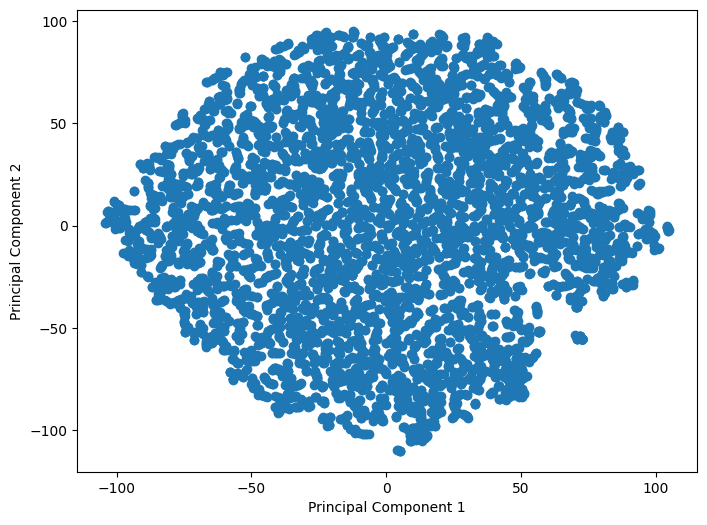

In [17]:
X = df.values
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.columns = ["pc1", "pc2"]
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded.loc[:,"pc1"], X_embedded.loc[:,"pc2"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")


,pc1,pc2,label
0,-62.088650,29.440784,0
1,-51.363159,38.902882,0
2,30.683178,12.824553,3
3,-10.202559,30.119665,0
4,12.374237,47.498608,1


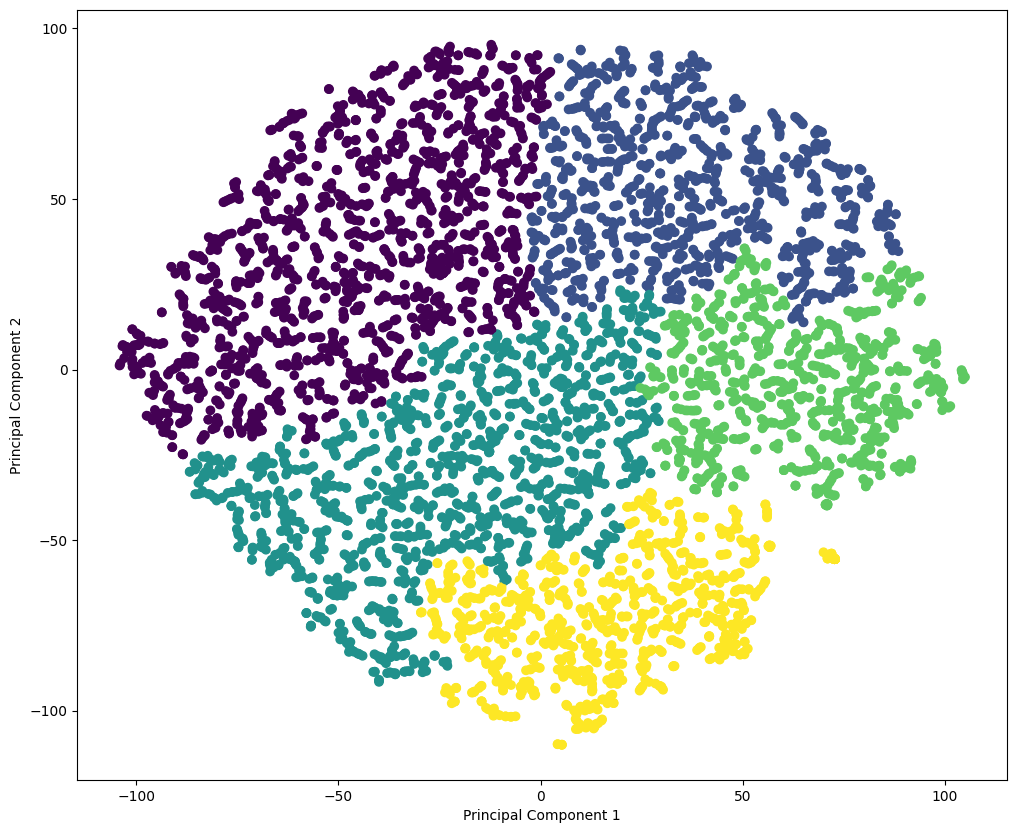

In [18]:
X = X_embedded.values
clustering = Birch(n_clusters=5).fit(X)
X_embedded["label"] = clustering.labels_
plt.figure(figsize=(12, 10))
plt.scatter(X_embedded["pc1"], X_embedded["pc2"], c=X_embedded["label"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
X_embedded.head()

/home/hmf6av/.local/lib/python3.11/site-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


,pc1,pc2,label
0,-62.088650,29.440784,0
1,-51.363159,38.902882,2292
2,30.683178,12.824553,908
3,-10.202559,30.119665,319
4,12.374237,47.498608,482


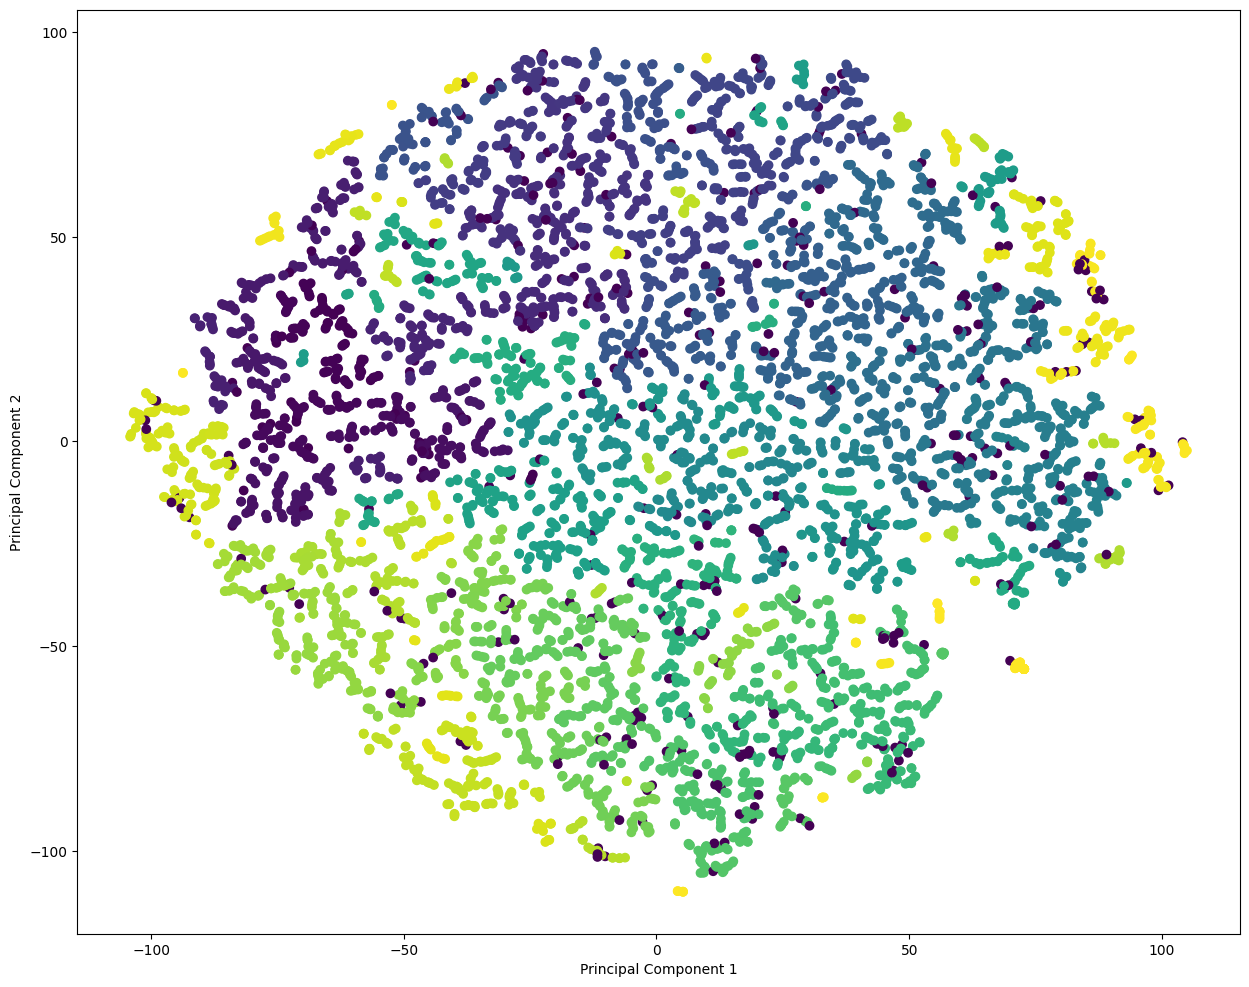

In [19]:
X = X_embedded.values
clustering = OPTICS(min_samples=2).fit(X)
X_embedded["label"] = clustering.labels_
plt.figure(figsize=(15, 12))
plt.scatter(X_embedded["pc1"], X_embedded["pc2"], c=X_embedded["label"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
X_embedded.head()

In [30]:
#Time Series Clustering
num_clusters = 3
model = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw",
                         max_iter=10)

In [31]:
model.fit(df)

TimeSeriesKMeans(max_iter=10, metric='dtw')

In [32]:
preds = model.predict(df)

/home/hmf6av/.local/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning:

2-Dimensional data passed. Assuming these are 7367 1-dimensional timeseries



In [33]:
centroids = []

for i in range(num_clusters):
    curr_series = model.cluster_centers_[i].ravel()
    centroid = pd.Series(data=curr_series)
    centroids.append(centroid)

In [34]:
cluster_df = pd.DataFrame({"cluster": preds}, index = df.index.values)

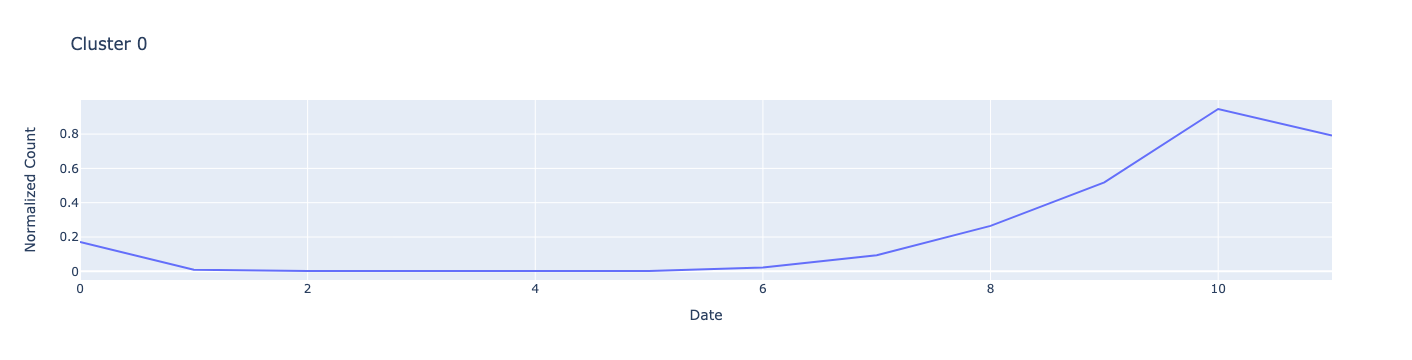

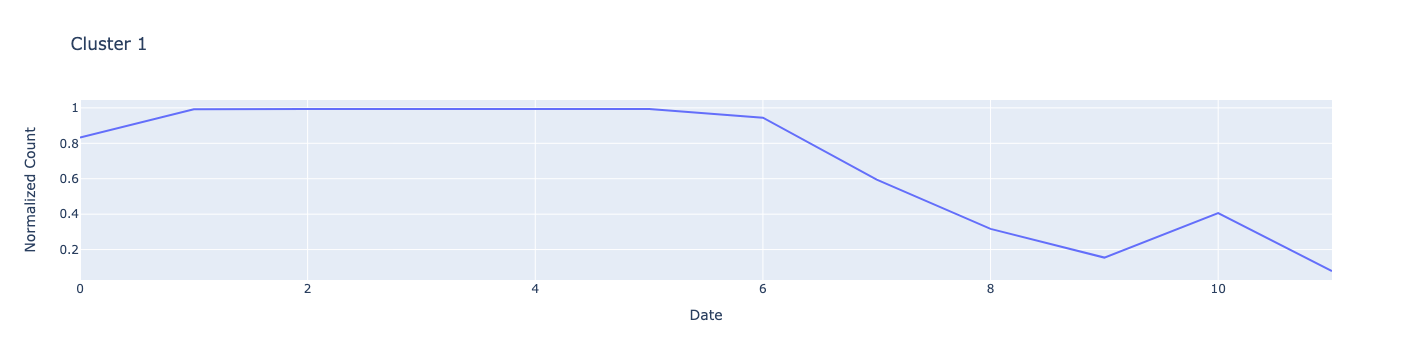

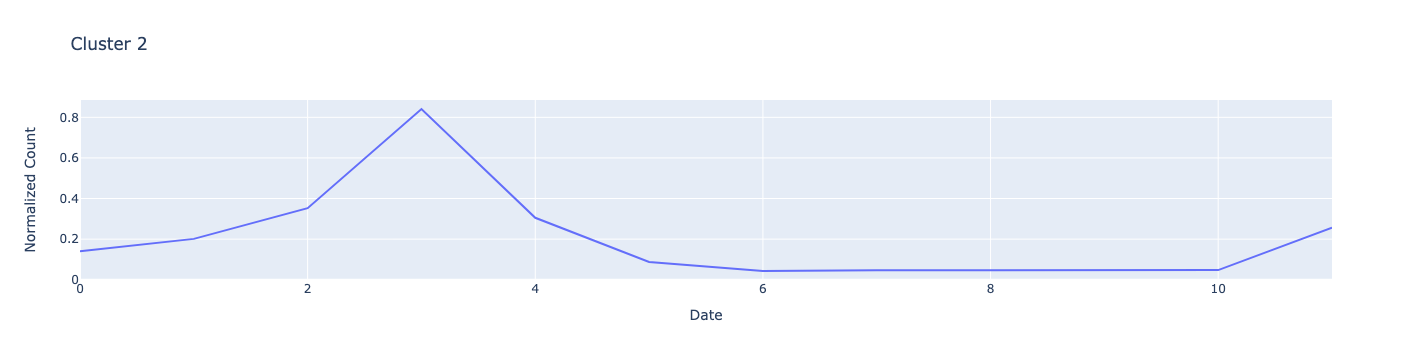

In [35]:
for i in range(num_clusters):
    fig = go.Figure()
    windows = cluster_df[cluster_df["cluster"] == i].index.values
    
    fig.add_trace(go.Scatter(y = centroids[i], mode = "lines", name = "Centroid"))
    """
    for window in windows:
        fig.add_trace(go.Scatter(y = df.loc[window], mode = "lines",
                                name = window))
    """
    fig.update_layout(title = f"Cluster {i}", xaxis_title = "Date", yaxis_title = "Normalized Count", hovermode = "x")
    fig.show()

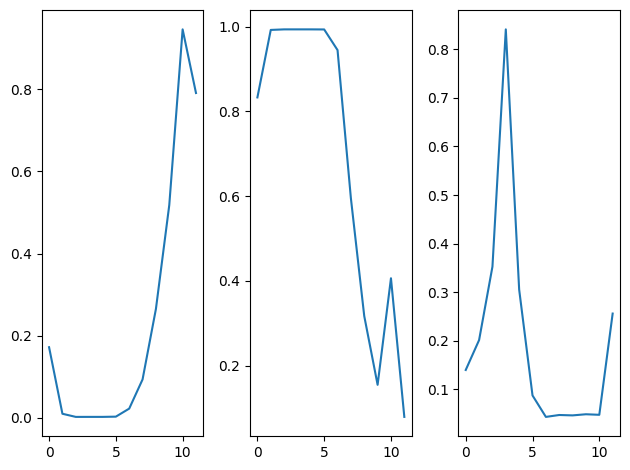

In [38]:
fig, ax = plt.subplots(1, 3)
for i in range(3):
    centroids[i].plot(ax = ax[i])
plt.tight_layout()

In [39]:
cluster_df.value_counts()

cluster
1          3110
0          2460
2          1797
dtype: int64

In [28]:
cluster_df

,cluster
Alabama_window_000,5
Alabama_window_001,0
Alabama_window_002,0
Alabama_window_003,0
Alabama_window_004,1
...,...
Wyoming_window_134,3
Wyoming_window_135,5
Wyoming_window_136,5
Wyoming_window_137,5


In [29]:
df.loc["Alabama_window_000"]

0     0.000000
1     0.133333
2     0.533333
3     0.166667
4     0.700000
5     1.000000
6     0.600000
7     0.400000
8     0.666667
9     0.600000
10    0.200000
11    0.666667
Name: Alabama_window_000, dtype: float64